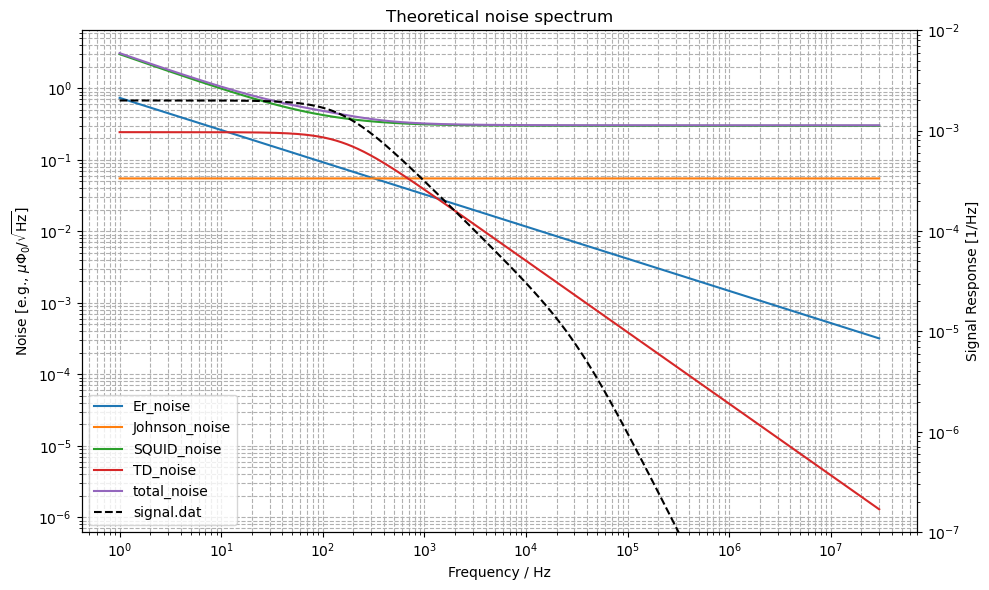

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Base path and list of files
base_path = "../Sim_Data/Al2O3_Al_athermal/"
file_names = [
    "Er_noise.dat",
    "Johnson_noise.dat",
    "SQUID_noise.dat",
    "TD_noise.dat",
    "total_noise.dat"
]

signal_file = "signal.dat"

# Prepare to load and plot noise data
fig, ax1 = plt.subplots(figsize=(10, 6))
data_dict = {}

# Plot noise data on the left Y-axis
for fname in file_names:
    full_path = os.path.join(base_path, fname)
    try:
        data = np.loadtxt(full_path)
        freq, values = data[:, 0], data[:, 1]
        data_dict[fname] = (freq, values)
        ax1.loglog(freq, values, label=fname.removesuffix('.dat'))
    except Exception as e:
        print(f"Could not read {fname}: {e}")

# Format left axis (noise)
ax1.set_xlabel("Frequency / Hz")
ax1.set_ylabel("Noise [e.g., $\\mu\\Phi_0/\\sqrt{\\mathrm{Hz}}$]")
ax1.grid(True, which='both', linestyle='--')

# Plot signal data on a second Y-axis
ax2 = ax1.twinx()
try:
    signal_data = np.loadtxt(os.path.join(base_path, signal_file))
    freq_sig, values_sig = signal_data[:, 0], signal_data[:, 1]
    data_dict[signal_file] = (freq_sig, values_sig)
    ax2.loglog(freq_sig, values_sig, label=signal_file, color='black', linestyle='--')
    ax2.set_ylabel("Signal Response [1/Hz]")
    ax2.set_ylim(1e-7, 1e-2)  # Set desired y-scale for signal
except Exception as e:
    print(f"Could not read {signal_file}: {e}")

# Add legends for both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

plt.title("Theoretical noise spectrum")
plt.tight_layout()
plt.show()


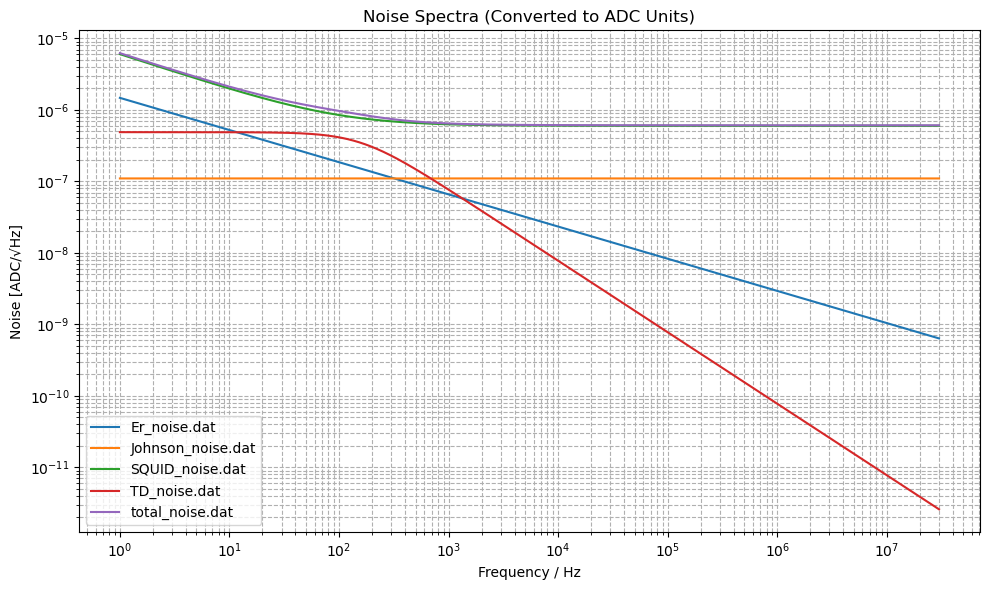

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Conversion function
def flux_noise_to_adc(flux_noise_uPhi0):
    """
    Convert flux noise (in μΦ₀/√Hz) to ADC counts/√Hz.
    Assumes: 1 Φ₀ = 1 V and 1 V = 2 ADC counts.
    """
    return flux_noise_uPhi0 * 2e-6

# Base path and list of files
base_path = "../Sim_Data/Al2O3_Al_athermal/"
file_names = [
    "Er_noise.dat",
    "Johnson_noise.dat",
    "SQUID_noise.dat",
    "TD_noise.dat",
    "total_noise.dat"
]

# Prepare to load and plot noise data
fig, ax = plt.subplots(figsize=(10, 6))
data_dict = {}

# Plot noise data on the left Y-axis (converted to ADC)
for fname in file_names:
    full_path = os.path.join(base_path, fname)
    try:
        data = np.loadtxt(full_path)
        freq, values_flux = data[:, 0], data[:, 1]
        values_adc = flux_noise_to_adc(values_flux)
        data_dict[fname] = (freq, values_adc)
        ax.loglog(freq, values_adc, label=fname)
    except Exception as e:
        print(f"Could not read {fname}: {e}")

# Format plot
ax.set_xlabel("Frequency / Hz")
ax.set_ylabel("Noise [ADC/√Hz]")
ax.grid(True, which='both', linestyle='--')
ax.legend(loc='lower left')
ax.set_title("Noise Spectra (Converted to ADC Units)")
plt.tight_layout()
plt.show()


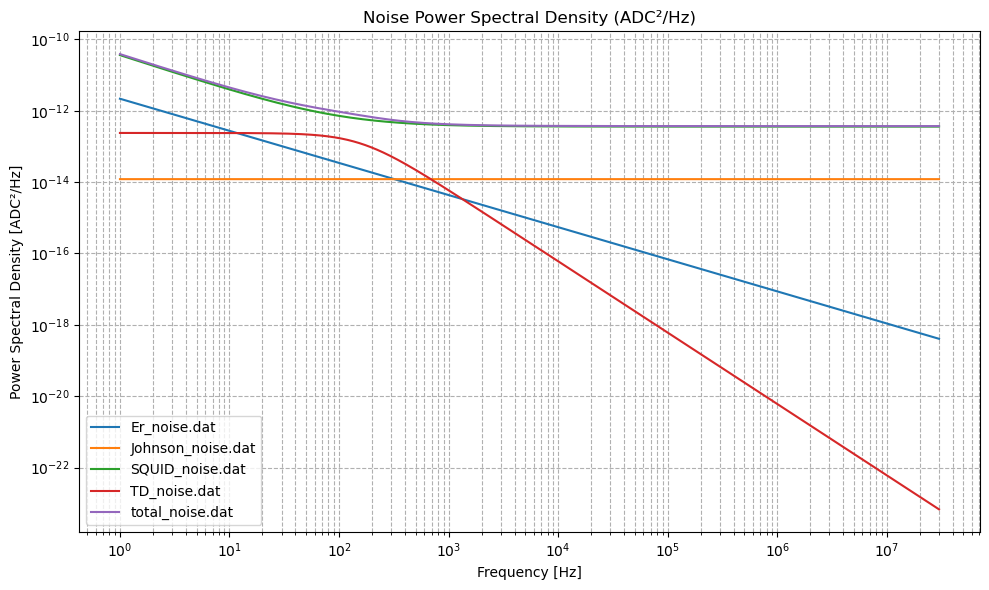

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Conversion function: flux noise (μΦ₀/√Hz) → ADC/√Hz
def flux_noise_to_adc(flux_noise_uPhi0):
    """
    Convert flux noise (in μΦ₀/√Hz) to ADC counts/√Hz.
    Assumes: 1 Φ₀ = 1 V and 1 V = 2 ADC counts.
    """
    return flux_noise_uPhi0 * 2e-6

# Base path and list of files
base_path = "../Sim_Data/Al2O3_Al_athermal/"
file_names = [
    "Er_noise.dat",
    "Johnson_noise.dat",
    "SQUID_noise.dat",
    "TD_noise.dat",
    "total_noise.dat"
]

# Prepare to load and plot noise data
fig, ax = plt.subplots(figsize=(10, 6))
data_dict = {}

# Process each file
for fname in file_names:
    full_path = os.path.join(base_path, fname)
    try:
        data = np.loadtxt(full_path)
        freq, values_flux = data[:, 0], data[:, 1]

        # Step 1: Convert flux noise to ADC/√Hz
        values_adc = flux_noise_to_adc(values_flux)

        # Step 2: Convert amplitude spectral density to power spectral density
        psd_adc = values_adc**2  # Now in ADC²/Hz

        # Store and plot
        data_dict[fname] = (freq, psd_adc)
        ax.loglog(freq, psd_adc, label=fname)
    except Exception as e:
        print(f"Could not read {fname}: {e}")

# Plot formatting
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Power Spectral Density [ADC²/Hz]")
ax.set_title("Noise Power Spectral Density (ADC²/Hz)")
ax.grid(True, which='both', linestyle='--')
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq
from scipy.interpolate import interp1d
import os

# === Parameters ===
sampling_rate = 3906250
ch45_template_path = "../templates/vac_templates/vac_ch45_low_eng.npy"
ch46_template_path = "../templates/vac_templates/vac_ch46plus_low_eng.npy"
k_alpha_template_path = "../templates/template_K_alpha_tight.npy"
mmc_path = "../templates/noise_psd_from_MMC.npy"

# === Load templates and PSD ===
for path in [ch45_template_path, ch46_template_path, k_alpha_template_path, mmc_path]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")

ch45_template = np.load(ch45_template_path)
ch46_template = np.load(ch46_template_path)
k_alpha_template = np.load(k_alpha_template_path)
mmc_psd = np.load(mmc_path)

# === Prepare FFT axis ===
N = len(ch45_template)
frequencies = rfftfreq(N, d=1.0 / sampling_rate)

# === Compute FFT amplitude spectra (A/√Hz) ===
fft_ch45 = np.abs(rfft(ch45_template)) / np.sqrt(sampling_rate * N)
fft_ch46 = np.abs(rfft(ch46_template)) / np.sqrt(sampling_rate * N)
fft_kalpha = np.abs(rfft(k_alpha_template)) / np.sqrt(sampling_rate * N)

# === Interpolate MMC PSD if needed ===
if len(mmc_psd) != len(frequencies):
    original_freq = np.linspace(frequencies[0], frequencies[-1], len(mmc_psd))
    mmc_psd = interp1d(original_freq, mmc_psd, bounds_error=False, fill_value="extrapolate")(frequencies)

# === Plot ===
plt.figure(figsize=(10, 6))

plt.loglog(frequencies, fft_ch45, label="Ch45 Template FFT (A/√Hz)")
plt.loglog(frequencies, fft_ch46, label="Ch46+ Template FFT (A/√Hz)")
plt.loglog(frequencies, fft_kalpha, label="K-alpha Template FFT (A/√Hz)")
plt.loglog(frequencies, mmc_psd, label="MMC Noise PSD (A²/Hz)", linestyle='--')

plt.title("Template FFTs vs MMC Noise PSD")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Spectral Density")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()


FileNotFoundError: Missing file: ../templates/vac_templates/vac_ch45_low_eng.npy

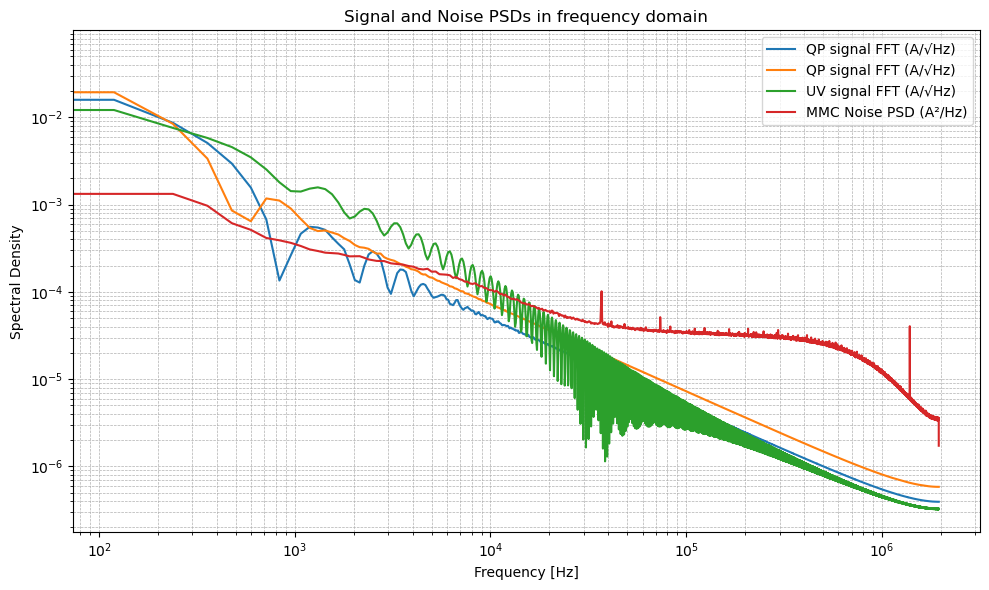

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq
from scipy.interpolate import interp1d
import os

# === Parameters ===
sampling_rate = 3906250
ch45_template_path = "../templates/vac_templates/vac_ch45_low_eng.npy"
ch46_template_path = "../templates/vac_templates/vac_ch46plus_low_eng.npy"
k_alpha_template_path = "../templates/template_K_alpha_tight.npy"
mmc_path = "../templates/noise_psd_from_MMC.npy"
color_noise_dir = "../templates/color"
color_types = ['white', 'pink', 'brownian', 'blue', 'violet']

# === Load and check all files ===
template_paths = [ch45_template_path, ch46_template_path, k_alpha_template_path, mmc_path]
for path in template_paths:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")

ch45_template = np.load(ch45_template_path)
ch46_template = np.load(ch46_template_path)
k_alpha_template = np.load(k_alpha_template_path)
mmc_psd = np.load(mmc_path)

# === Prepare FFT axis ===
N = len(ch45_template)
frequencies = rfftfreq(N, d=1.0 / sampling_rate)

# === Compute FFT amplitude spectra (A/√Hz) ===
fft_ch45 = np.abs(rfft(ch45_template)) / np.sqrt(sampling_rate * N)
fft_ch46 = np.abs(rfft(ch46_template)) / np.sqrt(sampling_rate * N)
fft_kalpha = np.abs(rfft(k_alpha_template)) / np.sqrt(sampling_rate * N)

# === Interpolate MMC PSD if needed ===
if len(mmc_psd) != len(frequencies):
    original_freq = np.linspace(frequencies[0], frequencies[-1], len(mmc_psd))
    mmc_psd = interp1d(original_freq, mmc_psd, bounds_error=False, fill_value="extrapolate")(frequencies)



# === Plot ===
plt.figure(figsize=(10, 6))

# Solid lines: template FFTs and MMC PSD
plt.loglog(frequencies, fft_ch45, label="QP signal FFT (A/√Hz)", linewidth=1.5)
plt.loglog(frequencies, fft_ch46, label="QP signal FFT (A/√Hz)", linewidth=1.5)
plt.loglog(frequencies, fft_kalpha, label="UV signal FFT (A/√Hz)", linewidth=1.5)
plt.loglog(frequencies, mmc_psd, label="MMC Noise PSD (A²/Hz)", linestyle='-', linewidth=1.5)


plt.title("Signal and Noise PSDs in frequency domain")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Spectral Density")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()
